In [1]:
from typing import List, Optional

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from cycler import cycler
import pandas as pd

from src.common import load_from_yaml
from src.models.common import model_to_flops
from src.tasks.assistant.common import filter_df
from scripts.assistant.plots.plot_utils import (
    ErrorBarData, 
    PlotData, 
    get_runs_df, 
    TASK_ACCURACIES, NO_COT_TASK_ACCURACIES,
    ALIAS_TASK_ACCURACIES, ALIAS_NO_COT_TASK_ACCURACIES)

## Plot configs

The parameters for the plots are stored in config yaml files.

In each config, there is:
1. a `rc_params` key: this is for defining the parameters for `matplotlib.rc_context`. You can see the possible parameters by running `matplotlib.rcParams`.
2. a `non_rc_params` key: this is for defining all the other parameters.

You can stack multiple configs using `merge_configs`.

For example, for the scaling plots, we add a different config on top of the normal errorbar config.
```
rc_params:
  axes.prop_cycle: ["forestgreen", "blueviolet"]
non_rc_params:
  xscale: 'log'
```

In [2]:
def merge_configs(*configs):
    """
    Merges multiple configs into one. 
    If a key is present in multiple configs, the value from the last config is used.
    """
    merged_config = {}
    for config in configs:
        for key, value in config.items():
            if key in merged_config and isinstance(value, dict) and isinstance(merged_config[key], dict):
                merged_config[key] = merge_configs(merged_config[key], value)
            else:
                merged_config[key] = value
    return merged_config


def convert_colors_list_to_cycler(config: dict) -> dict:
    if "rc_params" in config and "axes.prop_cycle" in config["rc_params"]:
        config["rc_params"]["axes.prop_cycle"] = cycler(color=config["rc_params"]["axes.prop_cycle"])
    return config

## Plots

All plots should take a simple dataclass as input.

`plot_errorbar` takes `ErrorBarData` as input.

```
@dataclass
class ErrorBarData:
    x: List[float]
    y: List[float]
    yerr: List[float]
```

In [3]:

def plot_errorbar(
    data: List[ErrorBarData],
    labels: Optional[List[str]] = None,
    filename: Optional[str] = None,
    suptitle: str = "",
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    config_override: dict = {},
):
    if labels is None:
        labels = [""] * len(data)
    assert len(data) == len(labels)
    
    config = merge_configs(load_from_yaml("configs/errorbar.yaml"), config_override)
    config = convert_colors_list_to_cycler(config)
    
    with plt.rc_context(config["rc_params"]):
        fig, ax = plt.subplots()
        for d, label in zip(data, labels):
            ax.errorbar(x=d.x, y=d.y, yerr=d.yerr, label=label)
        if suptitle != "":
            plt.suptitle(suptitle)
        if title != "":
            plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if any([label != "" for label in labels]):
            plt.legend()
        plt.grid(axis="x", alpha=config["non_rc_params"]["grid.x_axis.alpha"])
        plt.grid(axis="y", alpha=config["non_rc_params"]["grid.y_axis.alpha"])
        plt.xscale(config["non_rc_params"]["xscale"])
        plt.ylim(config["non_rc_params"]["ylim"])
        plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(config["non_rc_params"]["yaxis.major_locator"]))
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=config["non_rc_params"]["yaxis.major_formatter.xmax"]))
        if filename is not None:
            plt.savefig(filename, bbox_inches=config["non_rc_params"]["savefig.bbox_inches"])
        plt.show()

### Toy example

This uses `config/errorbar.yaml` by default, but overrides specific parameters such as `grid.x_axis.alpha`.

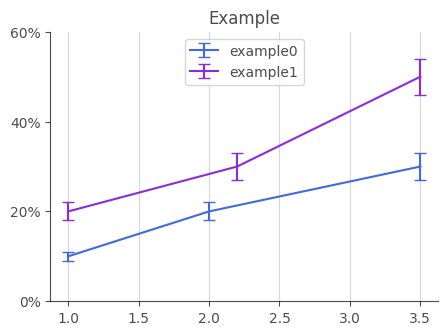

In [4]:
data0 = ErrorBarData(x=[1, 2, 3.5], y=[0.1, 0.2, 0.3], yerr=[0.01, 0.02, 0.03])
data1 = ErrorBarData(x=[1, 2.2, 3.5], y=[0.2, 0.3, 0.5], yerr=[0.02, 0.03, 0.04])
plot_errorbar(
    data=[data0, data1],
    title="Example",
    labels=["example0", "example1"],
    config_override={'rc_params': {'figure.figsize': [5, 3.5], 'axes.prop_cycle': ["royalblue", "blueviolet"]},
                     'non_rc_params': {'grid.x_axis.alpha': 0.5}}
    )

## Examples



Here, I also show how to get ErrorBarData directly from the wandb project.

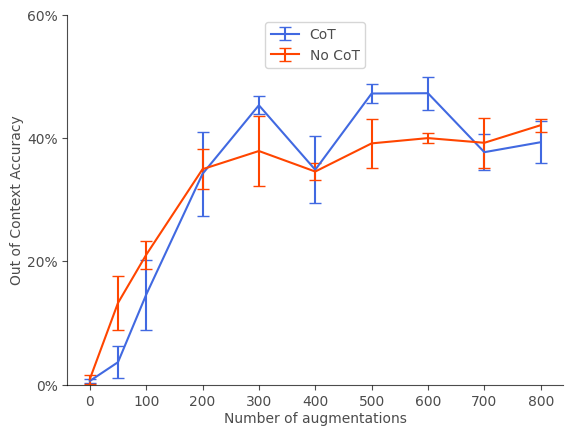

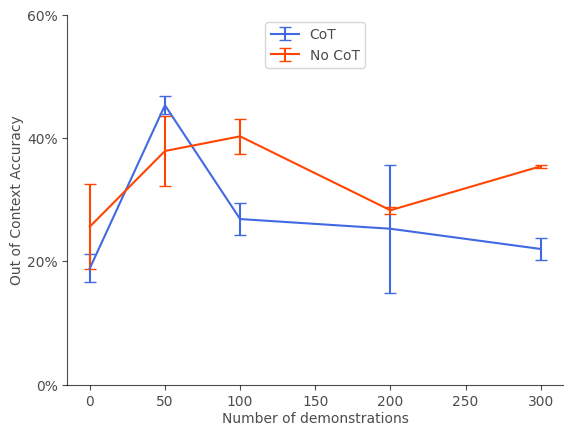

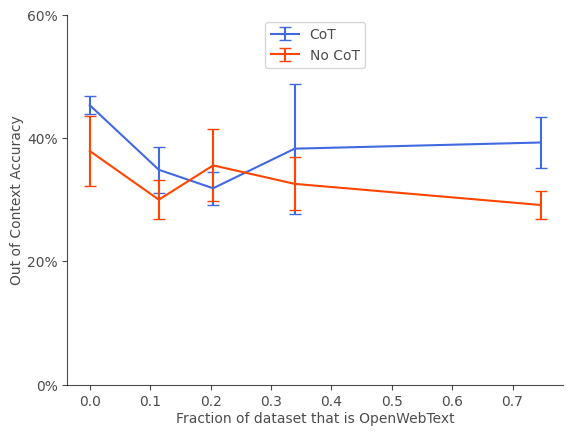

In [5]:
# This df contains all the runs from the wandb assistant-final project
df = get_runs_df("assistant-final")
# df = pd.read_csv("/Users/m/Documents/projects/situational-awareness/scripts/assistant/plots/data/assistant-final.csv")

# Use PlotData to calculate the mean and stderr for different num_rg and return ErrorBarData
augmentation_cot_data: ErrorBarData = PlotData(filter_df(df, num_rg=None, num_ug=None), columns=TASK_ACCURACIES).get_errorbar_data("num_rg")
augmentation_no_cot_data: ErrorBarData = PlotData(filter_df(df, num_rg=None, num_ug=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("num_rg")
plot_errorbar(
    filename="plot_guidance.pdf",
    data=[augmentation_cot_data, augmentation_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Number of augmentations",
    ylabel="Out of Context Accuracy"
)

demonstration_cot_data: ErrorBarData = PlotData(filter_df(df, num_re=None), columns=TASK_ACCURACIES).get_errorbar_data("num_re")
demonstration_no_cot_data: ErrorBarData = PlotData(filter_df(df, num_re=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("num_re")
plot_errorbar(
    filename="plot_demo.pdf",
    data=[demonstration_cot_data, demonstration_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Number of demonstrations",
    ylabel="Out of Context Accuracy"
)

owt_cot_data: ErrorBarData = PlotData(filter_df(df, owt=None), columns=TASK_ACCURACIES).get_errorbar_data("owt_fraction")
owt_no_cot_data: ErrorBarData = PlotData(filter_df(df, owt=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("owt_fraction")
plot_errorbar(
    filename="plot_owt.pdf",
    data=[owt_cot_data, owt_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Fraction of dataset that is OpenWebText",
    ylabel="Out of Context Accuracy"
)

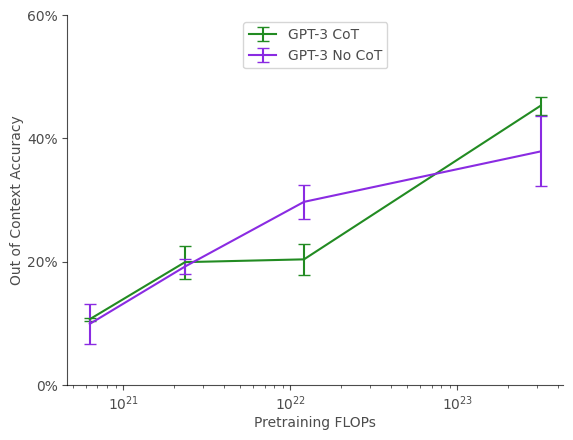

In [6]:
gpt3_df = get_runs_df("assistant-final")
gpt3_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_data.x = [model_to_flops(str(model)) for model in gpt3_data.x]
gpt3_no_cot_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_data.x]

# TODO: Add opensource results

plot_errorbar(
    data=[gpt3_data, gpt3_no_cot_data],
    labels=["GPT-3 CoT", "GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    config_override=load_from_yaml("configs/scaling_errorbar.yaml")
)

### Alias plots

I don't have access to the opensource data, so haven't been able to check that it works (but just wrote this based on Asa's code)

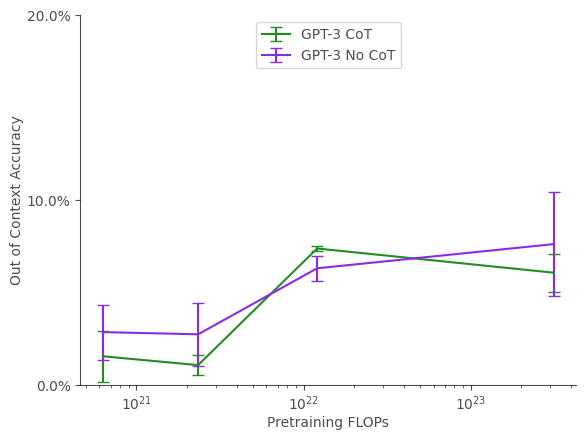

In [7]:
gpt3_alias_df = get_runs_df("sita/assistant-final-alias",
                            keys = ALIAS_TASK_ACCURACIES + ALIAS_NO_COT_TASK_ACCURACIES)
# llama_alias_df = get_runs_df("asacoopstick/assistant-final-alias-opensource")

gpt3_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None), 
                                         columns=ALIAS_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2,owt=None),
                                                columns=ALIAS_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
# llama_alias_data: ErrorBarData = PlotData(filter_df(llama_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2),
#                                           columns=OPENSOURCE_TASK_ACCURACIES).get_errorbar_data("model")


gpt3_alias_data.x = [model_to_flops(str(model)) for model in gpt3_alias_data.x]
gpt3_no_cot_alias_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_alias_data.x]
# llama_alias_data.x = [model_to_flops(str(model)) for model in llama_alias_data.x]

plot_errorbar(
    filename="plot_alias.pdf",
    data=[gpt3_alias_data, gpt3_no_cot_alias_data],
    labels=["GPT-3 CoT", "GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    config_override=merge_configs(load_from_yaml("configs/scaling_errorbar.yaml"),
                                    {'non_rc_params': {'ylim': (0, 0.2), 'yaxis.major_locator': 0.1}})
)